In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from typing import Tuple, List, Dict
from statsmodels.stats.multitest import multipletests

In [2]:
LINK_TO_DATASET = "https://drive.google.com/file/d/1ubNdFLbIOLQBBXbkbd3C0IZ1VcNmMKsz/view"

In [3]:
class ToolWindowAnalyzer:
    def __init__(self,
                 url: str,
                 download_name: str
                 ) -> None:
        file_id = url.split("/")[-2]
        download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        response = requests.get(download_url)
        file_name = download_name + '.csv'

        if not os.path.exists(file_name):
            with open(file_name, 'wb') as f:
                f.write(response.content)

        self.df = pd.read_csv(download_name + '.csv')
        self.episodes = None

    def _sort_data(self,
                  first_col: str,
                  second_col: str
                  ) -> None:
        self.df = self.df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

    def _show_rows(self,
                  num_rows: int = 5
                  ) -> None:
        display(self.df.head(num_rows))

    def _show_info(self) -> None:
        display(self.df.info())

    def _display_column(self,
                        column: str
                        ) -> None:
        display(self.df[column].value_counts(dropna=False))

    def _reconstruct_episodes(self) -> pd.DataFrame:
        episodes = []
        current_opens = {user_id: None for user_id in self.df['user_id'].unique()}

        for _, row in self.df.iterrows():
            user_id = row['user_id']

            if row['event'] == 'opened':
                warning = False

                # Checking multiple consecutive opens
                if current_opens[user_id] is not None:
                    warning = True
                    episodes.append({
                            'user_id': user_id,
                            'open_timestamp': current_opens[user_id]['timestamp'],
                            'close_timestamp': row['timestamp'],
                            'duration': row['timestamp'] -
                                        current_opens[user_id]['timestamp'],
                            'open_type': current_opens[user_id]['open_type'],
                            'warning': warning
                        })

                current_opens[user_id] = {
                    'timestamp': row['timestamp'],
                    'open_type': row['open_type'],
                    'warning': warning
                }

            elif row['event'] == 'closed':
                warning = False

                if current_opens[user_id] is not None:
                    open_event = current_opens[user_id]
                    duration = row['timestamp'] - open_event['timestamp']
                    if duration > 0:
                        episodes.append({
                            'user_id': user_id,
                            'open_timestamp': open_event['timestamp'],
                            'close_timestamp': row['timestamp'],
                            'duration': duration,
                            'open_type': open_event['open_type'],
                            'warning': open_event['warning']
                        })

                    # Remove the used open event
                    current_opens[user_id] = None
                else:
                    # Orphaned close event
                    warning = True
                    episodes.append({
                        'user_id': user_id,
                        'open_timestamp': row['timestamp'],
                        'close_timestamp': row['timestamp'],
                        'duration': 0,
                        'open_type': 'unknown',
                        'warning': True
                    })

        for user_id, open_event in current_opens.items():
            if open_event is not None:
                # Maximum timestamp as closing estimation with warning
                max_timestamp = self.df[self.df['user_id'] == user_id]['timestamp'].max()
                duration = max_timestamp - open_event['timestamp']
                episodes.append({
                    'user_id': user_id,
                    'open_timestamp': open_event['timestamp'],
                    'close_timestamp': max_timestamp,
                    'duration': duration,
                    'open_type': open_event['open_type'],
                    'warning': True
                })

        self.episodes = pd.DataFrame(episodes)

        # Print summary of warnings
        total_warnings = len(self.episodes[self.episodes['warning'] == True])
        print(f"Reconstructed {len(self.episodes)} episodes.")
        print(f"Episodes with warnings: {total_warnings} ({total_warnings / len(self.episodes)*100:.2f}%)")

        return self.episodes[self.episodes['warning'] == False].copy()



In [4]:
Task = ToolWindowAnalyzer(LINK_TO_DATASET, 'dataset')
Task._show_rows()
Task._show_info()

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  3503 non-null   int64 
 1   event      3503 non-null   object
 2   open_type  1865 non-null   object
 3   user_id    3503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.6+ KB


None

In [5]:
Task._sort_data('user_id', 'timestamp')

Task._display_column('event')
Task._display_column('open_type')
Task._display_column('user_id')

,count
event,
opened,1865
closed,1638


,count
open_type,
NaN,1638
auto,1204
manual,661


,count
user_id,
15,188
12,162
10,160
25,137
28,126
...,...
186,1
197,1
202,1


In [6]:
episodes = Task._reconstruct_episodes()
print(Task.episodes)

Reconstructed 1881 episodes.
Episodes with warnings: 351 (18.66%)
      user_id  open_timestamp  close_timestamp  duration open_type  warning
0           1   1751826102123    1751826746077    643954      auto    False
1           1   1751841258635    1751849544609   8285974    manual    False
2           1   1751985487772    1751986623885   1136113    manual    False
3           1   1752250204033    1752250204781       748    manual    False
4           1   1752250205587    1752257432775   7227188    manual    False
...       ...             ...              ...       ...       ...      ...
1876      189   1753262939775    1753262939775         0    manual     True
1877      197   1752061622119    1752061622119         0      auto     True
1878      202   1752063311786    1752063311786         0      auto     True
1879      204   1752107530446    1752107530446         0      auto     True
1880      205   1751869149911    1751869149911         0      auto     True

[1881 rows x 6 column

In [7]:
class CompareBoxplots:
    def __init__(self,
                 df: pd.DataFrame,
                 culumn_name: str = 'duration_seconds'
                 ) -> None:
        self.df = df
        self.auto_opens = self.df[self.df['open_type'] == 'auto'][culumn_name]
        self.manual_opens = self.df[self.df['open_type'] == 'manual'][culumn_name]

    def _display_column(self,
                        column: str
                        ) -> None:
        display(self.df[column].value_counts(dropna=False))

    def _comparison_timestamp(self,
                              plot_size: Tuple[int] = (12, 5),
                              bins: int = 42,
                              alpha: float = 0.5,
                              column_name: str = 'duration_seconds',
                              file_name: str = 'Duration_comparison_hist.png'
                              ) -> None:
        median_duration = self.df[column_name].median()
        mean_duration = self.df[column_name].mean()

        plt.figure(figsize=plot_size)
        plt.hist(self.auto_opens, bins=bins, alpha=alpha,
                label='Auto', color='skyblue')
        plt.hist(self.manual_opens, bins=bins, alpha=alpha,
                label='Manual', color='lightcoral')
        plt.axvline(median_duration, color='green', linestyle='dashed',
                    linewidth=2, label='Median (Filtered Events)')
        plt.axvline(mean_duration, color='black', linestyle='dashed',
                    linewidth=2, label='Mean (Filtered Events)')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Durations by Event Type (Filtered Data)')
        plt.legend()
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        plt.show()

    def _create_boxplots(self,
                         style: str = 'seaborn-v0_8',
                         plot_size: Tuple[int] = (12, 5),
                         labels: List[str] = ['Manual Opens', 'Automatic Opens'],
                         colors: List[str] = ['lightcoral', 'skyblue'],
                         alpha: float = 0.5
                         ) -> None:
        plt.style.use(style)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
        data = [self.manual_opens, self.auto_opens]

        # Main boxplot
        boxplot = ax1.boxplot(data,
                              tick_labels=labels,
                              patch_artist=True,
                              showfliers=False,
                              widths=0.6
                  )

        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha)

        for element in ['whiskers', 'caps', 'medians']:
            plt.setp(boxplot[element], color='black', linewidth=1.5)

        ax1.set_title('Tool Window Duration Distribution\nby Open Type',
                    fontsize=16, fontweight='bold', pad=16)
        ax1.set_ylabel('Duration (seconds)', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.tick_params(axis='x', labelsize=11)

        # Add annotations below the x-axis labels
        for i, (label, n) in enumerate(zip(labels, [len(self.manual_opens), len(self.auto_opens)])):
            ax1.text(i + 1, ax1.get_ylim()[0] - (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.15, # Adjusted y-position
                    f'n={n}', ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round, pad=0.2", facecolor='white', alpha=0.75))


        # Violin plot
        violin_parts = ax2.violinplot(data, showmedians=True, showextrema=False)

        for i, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')

        violin_parts['cmedians'].set_color('black')
        medians = [np.median(self.manual_opens), np.median(self.auto_opens)]
        ax2.scatter([1, 2], medians, color='white',
                    s=75, zorder=3, label='Median')
        ax2.set_xticks([1, 2])
        ax2.set_xticklabels(labels)
        ax2.set_title('Duration Distribution Density\n(Violin Plot)',
                    fontsize=16, fontweight='bold', pad=20)
        ax2.set_ylabel('Duration (seconds)', fontsize=12)
        ax2.grid(True, alpha=0.25, axis='y')
        ax2.legend()

        # Add summary statistics as text
        stats_text = (
            f"Manual Opens:\n"
            f"Median: {np.median(self.manual_opens):.2f}s\n"
            f"Mean: {np.mean(self.manual_opens):.2f}s\n"
            f"IQR: {np.percentile(self.manual_opens, 75) - np.percentile(self.manual_opens, 25):.2f}s\n"
            f"Std: {np.std(self.manual_opens):.2f}s\n\n"
            f"Automatic Opens:\n"
            f"Median: {np.median(self.auto_opens):.2f}s\n"
            f"Mean: {np.mean(self.auto_opens):.2f}s\n"
            f"IQR: {np.percentile(self.auto_opens, 75) - np.percentile(self.auto_opens, 25):.2f}s\n"
            f"Std: {np.std(self.auto_opens):.2f}s"
        )

        fig.text(0.75, 0.65, stats_text, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.75),
                verticalalignment='top')
        plt.tight_layout()
        plt.savefig('Duration_comparison_boxplots.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _perform_statistical_tests(self, percentile_cutoff: int) -> Dict[str, str]:
        """
        Perform statistical tests with duration limit and multiple testing correction.
        """
        print("STATISTICAL ANALYSIS")

        # Apply quantile limit
        manual_filtered = self.manual_opens[self.manual_opens <=
                                       np.percentile(self.manual_opens, percentile_cutoff)]
        auto_filtered = self.auto_opens[self.auto_opens <=
                                        np.percentile(self.auto_opens, percentile_cutoff)]

        print(f"Manual opens after filtering: {len(manual_filtered)}/{len(self.manual_opens)} "
              f"({len(manual_filtered)/len(self.manual_opens)*100:.1f}%)")
        print(f"Auto opens after filtering: {len(auto_filtered)}/{len(self.auto_opens)} "
              f"({len(auto_filtered)/len(self.auto_opens)*100:.1f}%)")

        # Test variance
        try:
            levene_stat, levene_p = stats.levene(manual_filtered, auto_filtered)
            print(f"Levene's test: W={levene_stat:.4f}, p={levene_p:.4f}")

            if levene_p < 0.05:
                print("Significant difference in variances (p < 0.05)")
            else:
                print("No significant difference in variances (p >= 0.05)")
        except Exception as e:
            print(f"Levene's test failed: {e}")
            levene_p = 1.0

        # Test difference in medians using Mann-Whitney U test
        print("Mann-Whitney U test to Median Comparison:")
        try:
            mw_stat, mw_p = stats.mannwhitneyu(manual_filtered, auto_filtered,
                                        alternative='two-sided', method='auto')
            print(f"Mann-Whitney U test: U={mw_stat:.0f}, p={mw_p:.4f}")
            n1, n2 = len(manual_filtered), len(auto_filtered)
            mw_effect_size = mw_stat / (n1 * n2)
            print(f"Mann-Whitney effect size: {mw_effect_size:.4f}")
        except Exception as e:
            print(f"Mann-Whitney test failed: {e}")
            mw_p = 1.0
            mw_effect_size = 0

        # Benjamini-Hochberg FDR correction
        print("\nMultiple testing correction")
        p_values = [levene_p, mw_p]
        test_names = ["Levene's test", "Mann-Whitney U test"]
        rejected, corrected_pvals, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

        for i, (name, orig_p, corr_p, rej) in enumerate(zip(test_names, p_values, corrected_pvals, rejected)):
            print(f"{name}:")
            print(f"Original p-value: {orig_p:.6f}")
            print(f"FDR-corrected p-value: {corr_p:.6f}")
            print(f"Significant after correction: {rej}")

        # Summary statistics
        print("\nSUMMARY RAPORT:")
        manual_median = np.median(manual_filtered)
        auto_median = np.median(auto_filtered)
        manual_mean = np.mean(manual_filtered)
        auto_mean = np.mean(auto_filtered)
        manual_iqr = np.percentile(manual_filtered, 75) - np.percentile(manual_filtered, 25)
        auto_iqr = np.percentile(auto_filtered, 75) - np.percentile(auto_filtered, 25)

        print(f"Manual opens (N={len(manual_filtered)}):")
        print(f"Median: {manual_median:.2f}s")
        print(f"Mean: {manual_mean:.2f}s")
        print(f"IQR: {manual_iqr:.2f}s")

        print(f"Automatic opens (N={len(auto_filtered)}):")
        print(f"Median: {auto_median:.2f}s")
        print(f"Mean: {auto_mean:.2f}s")
        print(f"IQR: {auto_iqr:.2f}s")

        return {
            'levene_test': (levene_stat, levene_p, corrected_pvals[0]),
            'mann_whitney': (mw_stat, mw_p, corrected_pvals[1]),
            'effect_size': mw_effect_size,
            'manual_stats': {
                'n': len(manual_filtered),
                'median': manual_median,
                'mean': manual_mean,
                'iqr': manual_iqr
            },
            'auto_stats': {
                'n': len(auto_filtered),
                'median': auto_median,
                'mean': auto_mean,
                'iqr': auto_iqr
            }
        }

    def plot_percentile_filtering_effect(self,
                                         percentile_cutoff: int = 90,
                                         bins: int = 75,
                                         alpha: float = 0.75):
        """ Visualize the effect of percentile filtering on both groups.
        """
        # Calculate thresholds
        manual_threshold = np.percentile(self.manual_opens, percentile_cutoff)
        auto_threshold = np.percentile(self.auto_opens, percentile_cutoff)
        manual_filtered = self.manual_opens[self.manual_opens <= manual_threshold]
        auto_filtered = self.auto_opens[self.auto_opens <= auto_threshold]

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Before filtering - Manual
        ax1.hist(self.manual_opens, bins=bins, alpha=alpha, color='blue', label='All data')
        ax1.axvline(manual_threshold, color='red', linestyle='--',
                    label=f'{percentile_cutoff}% cutoff: {manual_threshold:.1f}s')
        ax1.set_title(f'Manual Opens - Before Filtering\n(N={len(self.manual_opens)})')
        ax1.set_xlabel('Duration (seconds)')
        ax1.set_ylabel('Frequency')
        ax1.legend()
        ax1.grid(True, alpha=(alpha / 2))

        # After filtering - Manual
        ax2.hist(manual_filtered, bins=bins, alpha=alpha, color='green',
                label=f'Filtered ({len(manual_filtered)} episodes)')
        ax2.set_title(f'Manual Opens - After {percentile_cutoff}% Cutoff\n'
                      f'Removed: {len(self.manual_opens) - len(manual_filtered)} episodes')
        ax2.set_xlabel('Duration (seconds)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=(alpha / 2))

        # Before filtering - Auto
        ax3.hist(self.auto_opens, bins=bins, alpha=alpha, color='orange', label='All data')
        ax3.axvline(auto_threshold, color='red', linestyle='--',
                    label=f'{percentile_cutoff}% cutoff: {auto_threshold:.1f}s')
        ax3.set_title(f'Automatic Opens - Before Filtering\n(N={len(self.auto_opens)})')
        ax3.set_xlabel('Duration (seconds)')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=(alpha / 2))

        # After filtering - Auto
        ax4.hist(auto_filtered, bins=bins, alpha=alpha, color='purple',
                label=f'Filtered ({len(auto_filtered)} episodes)')
        ax4.set_title(f'Automatic Opens - After {percentile_cutoff}% Cutoff\n'
                      f'Removed: {len(self.auto_opens) - len(auto_filtered)} episodes')
        ax4.set_xlabel('Duration (seconds)')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=(alpha / 2))

        plt.tight_layout()
        plt.savefig(f'percentile_filtering_{percentile_cutoff}.png', dpi=300, bbox_inches='tight')
        plt.show()

In [8]:
episodes['duration_seconds'] = episodes['duration'] / 1000
Opens = CompareBoxplots(episodes[['duration_seconds',
                                  'open_type']].where(episodes['warning'] == False))
Opens._display_column('open_type')

,count
open_type,
auto,922
manual,608


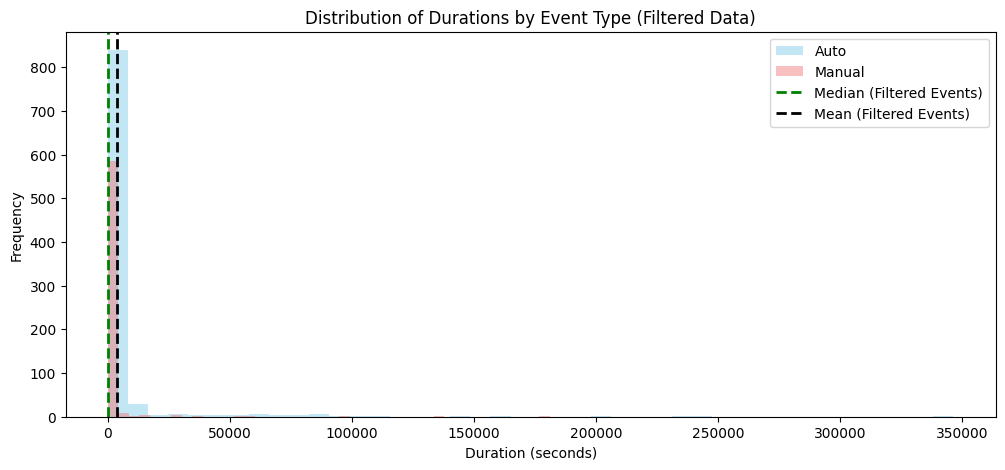

In [9]:
Opens._comparison_timestamp()

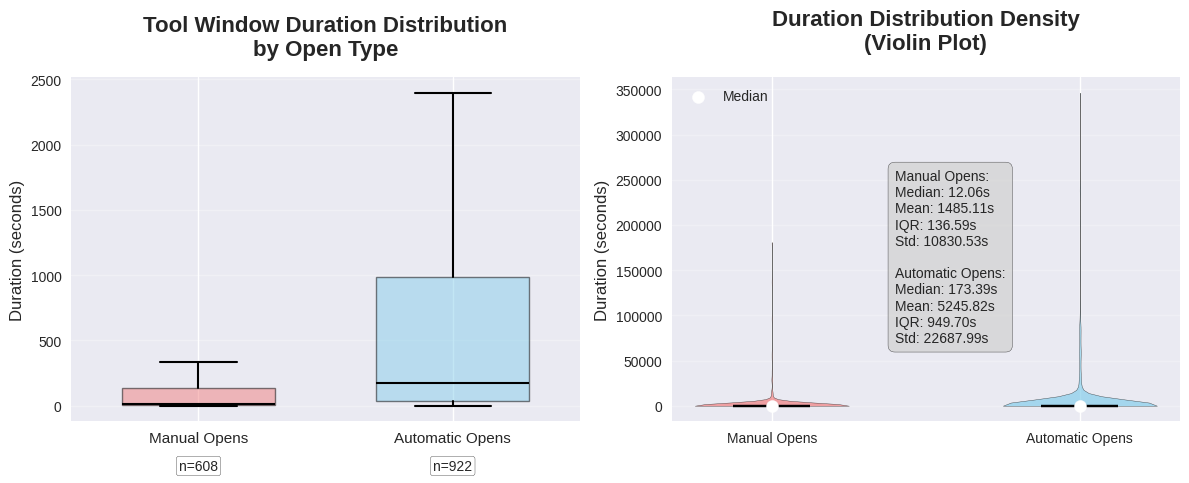

In [10]:
Opens._create_boxplots()

In [11]:
result = Opens._perform_statistical_tests(percentile_cutoff=95)

STATISTICAL ANALYSIS
Manual opens after filtering: 577/608 (94.9%)
Auto opens after filtering: 875/922 (94.9%)
Levene's test: W=62.3896, p=0.0000
Significant difference in variances (p < 0.05)
Mann-Whitney U test to Median Comparison:
Mann-Whitney U test: U=117050, p=0.0000
Mann-Whitney effect size: 0.2318

Multiple testing correction
Levene's test:
Original p-value: 0.000000
FDR-corrected p-value: 0.000000
Significant after correction: True
Mann-Whitney U test:
Original p-value: 0.000000
FDR-corrected p-value: 0.000000
Significant after correction: True

SUMMARY RAPORT:
Manual opens (N=577):
Median: 9.78s
Mean: 150.06s
IQR: 87.23s
Automatic opens (N=875):
Median: 155.79s
Mean: 1182.48s
IQR: 751.31s


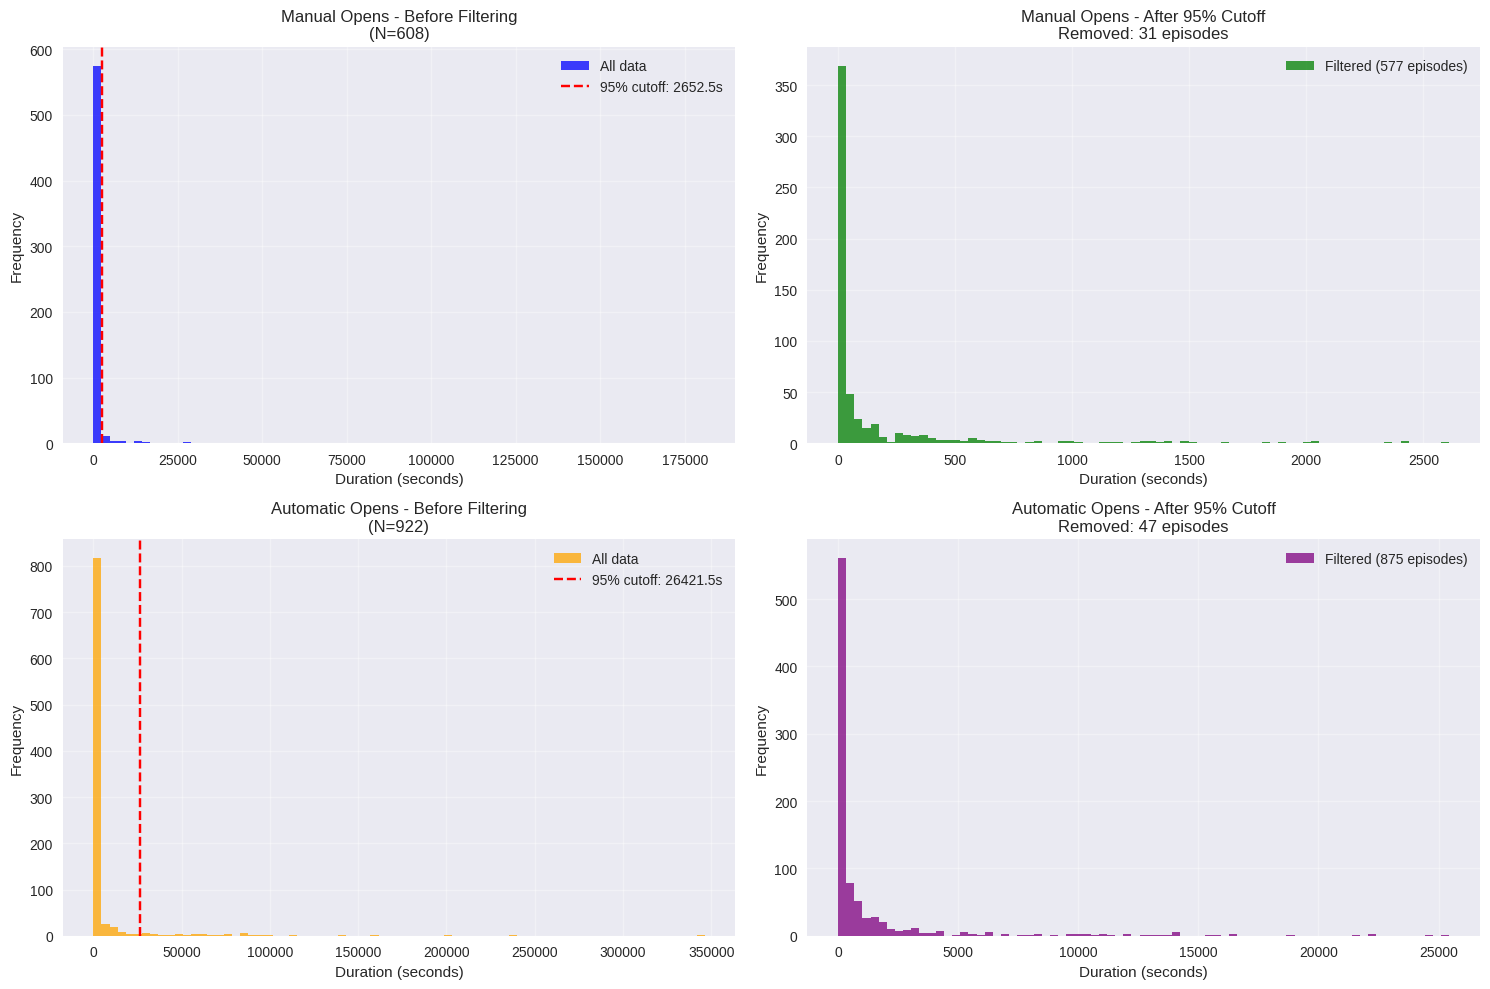

In [12]:
Opens.plot_percentile_filtering_effect(percentile_cutoff=95)